In [4]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma
from tensorflow_probability import abc

/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [38]:
# 定义先验分布
# 定义先验分布
def prior_fun(batch_size=1):
    # 定义 miu 的先验: N(mean, stddev)
    mean, stddev = 10.0, 1.0
    miu_dist = tfp.distributions.Bernoulli(0.5)
    miu_samples = tf.cast(miu_dist.sample(batch_size), dtype=tf.float32)

    # 定义 sigma^2 的先验: InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = tf.cast(sigma2_dist.sample(batch_size), dtype=tf.float32)
    # 修正维度，返回形状为 (batch_size, 2) 的张量
    return tf.concat([miu_samples[:, None], sigma2_samples[:, None]], axis=-1)


# 定义似然函数（模拟器）
def likelihood_fun(params, n_obs=1000):
    miu = params[:, 0]  # 提取 miu
    sigma2 = params[:, 1]  # 提取 sigma^2
    return tf.random.normal(
        shape=(params.shape[0], n_obs, 1),
        mean=miu[:, None],
        stddev=tf.sqrt(sigma2)[:, None]
    )

In [39]:
# 定义生成模型
prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# 定义总结网络
summary_net = bf.networks.DeepSet(summary_dim=10)

# 定义推断网络
inference_net = bf.networks.InvertibleNetwork(
    num_params=2,
    num_coupling_layers=4,
)

# 定义后验推断器
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)



INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [ ]:
# 定义 Trainer
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

# 执行一次模型调用（可选，用于验证模型是否工作正常）
_ = model(batch_size=32)

# 开始在线训练
history = trainer.train_online(
    epochs=5,               # 训练 10 个 epoch
    iterations_per_epoch=500,  # 每个 epoch 的迭代次数
    batch_size=32,            # 每次训练的批量大小
    validation_sims=200    # 验证集样本数
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1:  67%|██████▋   | 335/500 [00:49<00:22,  7.38it/s, Epoch: 1, Iter: 335,Loss: -1.147,W.Decay: 0.165,Avg.Loss: 34.077,Avg.W.Decay: 0.180,LR: 4.78E-04]   

In [41]:
# 自定义生成模型的 configurator
def custom_configurator(simulation_outputs):
    """仅保留 miu 的后验估计"""
    prior_draws = simulation_outputs['prior_draws']
    configured_outputs = {
        'parameters': prior_draws[:, 0],  # 只保留 miu
        'summary_conditions': simulation_outputs['sim_data'],    # 保留原始数据
        'direct_conditions': None
    }
    return configured_outputs

# 定义 Trainer 并使用自定义 configurator
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=custom_configurator  # 使用自定义配置器
)

# 开始训练
history = trainer.train_online(
    epochs=1,
    iterations_per_epoch=500,
    batch_size=32,
    validation_sims=200
)


INFO:root:Performing a consistency check with provided components...


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 Exception encountered when calling layer 'dense_coupling_net_64' (type DenseCouplingNet).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Ranks of all input tensors should match: shape[0] = [2,1] vs. shape[1] = [2,1,10] [Op:ConcatV2] name: concat

Call arguments received by layer 'dense_coupling_net_64' (type DenseCouplingNet):
  • target=tf.Tensor(shape=(2, 1), dtype=float32)
  • condition=tf.Tensor(shape=(2, 1, 10), dtype=float32)
  • kwargs={'training': 'None'}

In [33]:
# 1. 生成真实数据
# 假设真实数据从 N(0, 1) 分布生成
n_obs = 1000  # 样本数量
true_miu = 10  # 真实均值
true_sigma = 0.3  # 真实标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)

In [34]:
posterior_samples

array([[10.23357   ,  0.01515321],
       [10.007245  ,  1.7495906 ],
       [10.45796   ,  0.5979026 ],
       ...,
       [ 9.622382  ,  0.2869066 ],
       [10.501088  ,  0.33167598],
       [10.689957  ,  1.3206286 ]], dtype=float32)

In [25]:
# 验证自定义配置器是否正确工作
test_output = model(batch_size=3)  # 模拟一些输出
configured_output = custom_configurator(test_output)

print("原始 prior_draws:", test_output['prior_draws'])
print("变换后的 parameters:", configured_output['parameters'])


原始 prior_draws: [[[-1.4538511   0.55349874]]

 [[-0.7475304   0.36654112]]

 [[-0.7921741   0.43531924]]]
变换后的 parameters: tf.Tensor(
[[[        nan -0.5914958 ]]

 [[        nan -1.0036446 ]]

 [[        nan -0.83167565]]], shape=(3, 1, 2), dtype=float32)


In [16]:
# # 自定义生成模型的 configurator，增加 log(sigma^2) 的变换
# def custom_configurator_with_transform(simulation_outputs):
#     """对 sigma^2 进行 log 变换，并保留 miu 和 log(sigma^2)"""
#     prior_draws = simulation_outputs['prior_draws']
#     transformed_sigma2 = tf.math.log(prior_draws[:, 1:2])  # 对 sigma^2 取对数
#     transformed_params = tf.concat([prior_draws[:, 0:1], transformed_sigma2], axis=-1)  # 拼接 miu 和 log(sigma^2)
# 
#     configured_outputs = {
#         'parameters': transformed_params,           # 使用变换后的参数
#         'summary_conditions': simulation_outputs['sim_data'],  # 保留原始数据
#         'direct_conditions': None
#     }
#     return configured_outputs
# 
# # 定义 Trainer 并使用自定义 configurator
# trainer = bf.trainers.Trainer(
#     amortizer=amortizer,
#     generative_model=model,
#     configurator=custom_configurator_with_transform  # 使用包含变换的配置器
# )
# 
# # 开始训练
# history = trainer.train_online(
#     epochs=5,
#     iterations_per_epoch=500,
#     batch_size=32,
#     validation_sims=200
# )


INFO:root:Performing a consistency check with provided components...


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 {{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [2,1,2] vs. shape[1] = [2,0,2] [Op:ConcatV2] name: concat

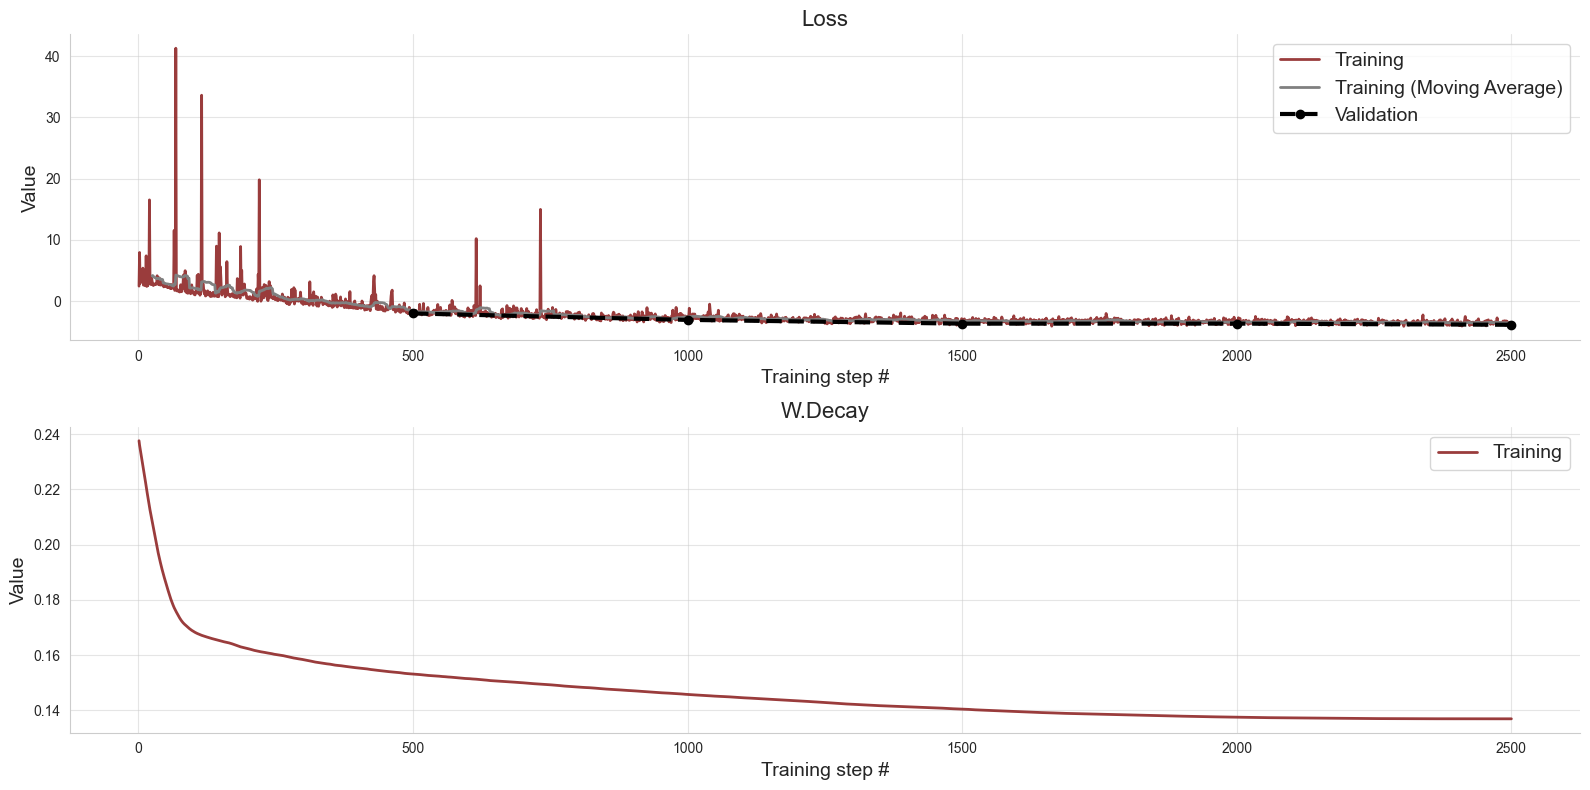

In [142]:
# # 可视化训练和验证损失
# f = bf.diagnostics.plot_losses(
#     history["train_losses"], 
#     history["val_losses"], 
#     moving_average=True
# )

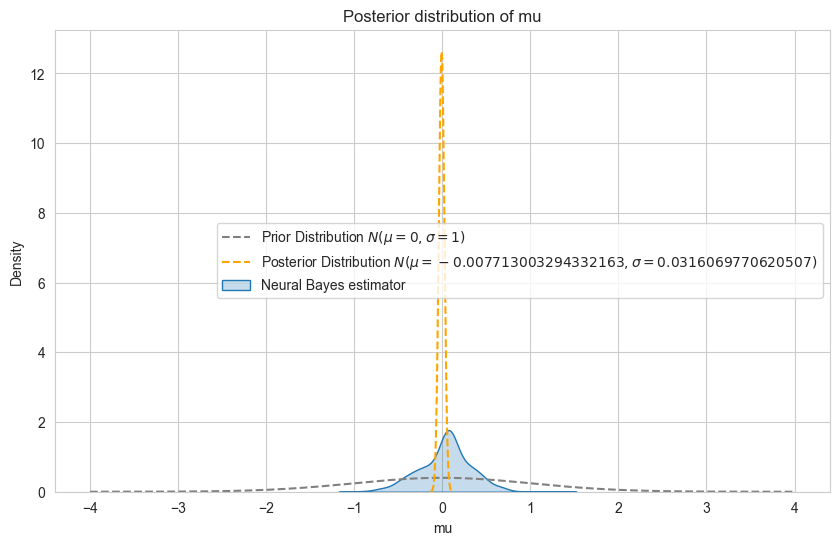

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 定义 Normal 分布
normal_prior = torch.distributions.Normal(loc=torch.tensor(mu_prior), scale=torch.tensor(sigma_prior))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_prior = torch.linspace(mu_prior - 4 * sigma_prior, mu_prior + 4 * sigma_prior, 500)
pdf_normal_prior = torch.exp(normal_prior.log_prob(x_prior))

# 添加 Prior Distribution 的曲线
ax.plot(x_prior.numpy(), pdf_normal_prior.numpy(), 
        label=f"Prior Distribution $N(\mu={mu_prior}, \sigma={sigma_prior})$", 
        color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 定义 Normal 分布
normal_poster = torch.distributions.Normal(loc=torch.tensor(mu_poster), scale=torch.tensor(sigma_poster))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_poster = torch.linspace(mu_poster - 4 * sigma_poster, mu_poster + 4 * sigma_poster, 500)
pdf_normal_poster = torch.exp(normal_poster.log_prob(x_poster))

# 添加 Posterior Distribution 的曲线
ax.plot(x_poster.numpy(), pdf_normal_poster.numpy(), 
        label=f"Posterior Distribution $N(\mu={mu_poster}, \sigma={sigma_poster})$", 
        color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

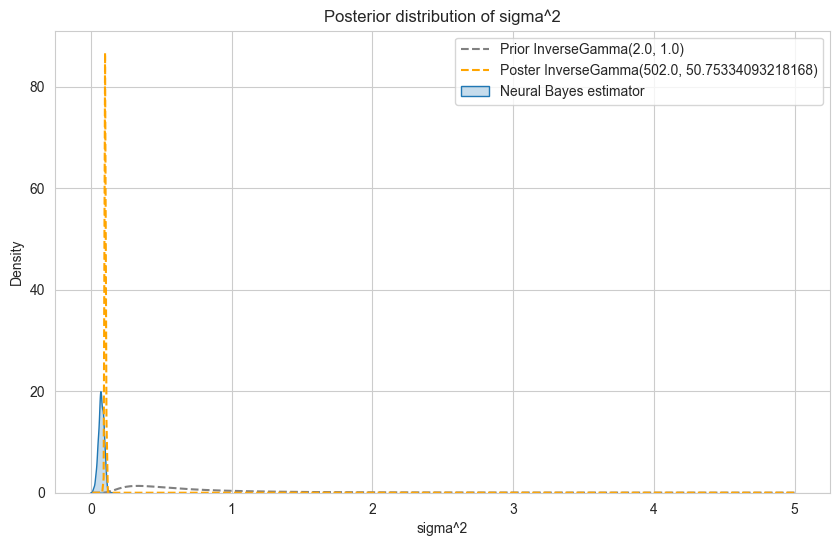

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 定义 InverseGamma 分布
concentration = torch.tensor(2.0)  # 形状参数 α
rate = torch.tensor(1.0)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Prior InverseGamma({concentration}, {rate})", color="grey", linestyle="--")

# 定义 InverseGamma 分布
concentration = torch.tensor(alpha_poster)  # 形状参数 α
rate = torch.tensor(beta_poster)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Poster InverseGamma({concentration}, {rate})", color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Summary vector shape:  (1, 100, 10)
Posterior samples shape:  (100, 2)


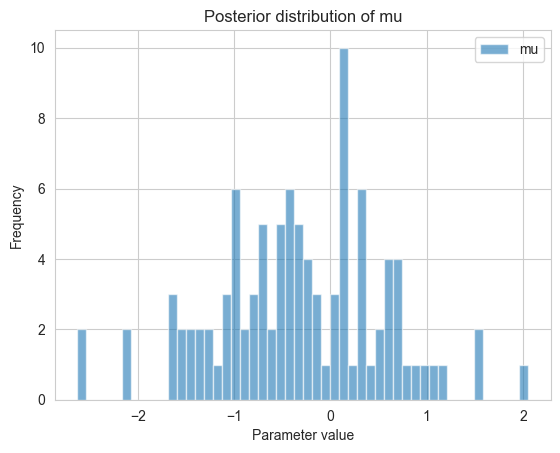

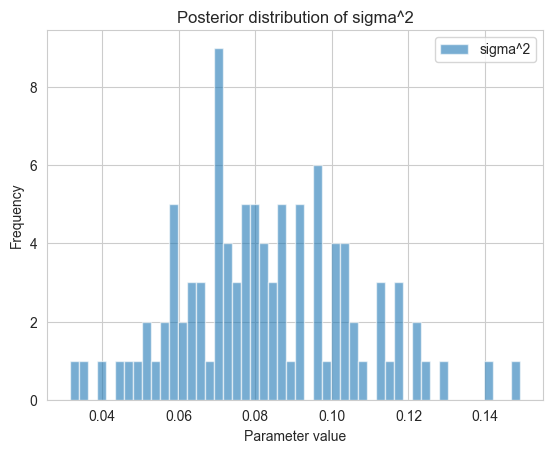

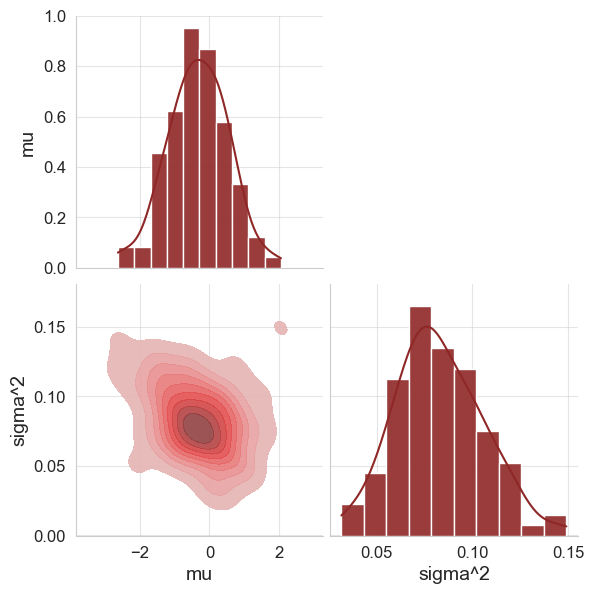

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 生成真实数据
# 假设真实数据从 N(0, 1) 分布生成
n_obs = 100  # 样本数量
true_miu = -0.3  # 真实均值
true_sigma = 1  # 真实标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

# 2. 使用总结网络提取观测数据特征
# 总结网络将数据转换为固定长度的特征向量
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # 应输出形状 (1, summary_dim)

# 3. 推断后验分布
# 使用推断网络对观测数据进行推断
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=100)
print("Posterior samples shape: ", posterior_samples.shape)  # 应输出形状 (1000, 2)

# 4. 可视化后验分布
# 参数名称
param_names = ["mu", "sigma^2"]

# 绘制每个参数的后验分布直方图
for i in range(posterior_samples.shape[1]):  # 遍历 mu 和 sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()

# 5. 可视化参数的二维联合分布
# 使用诊断工具绘制联合分布
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [149]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = n_obs  # 样本数量

# 计算样本总方差
variance = np.sum((Z - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 52.0
Posterior beta: 38.82151166374386
Posterior mu (mean): -0.35014533170379036
Posterior sigma^2 (variance): 0.009900990099009901


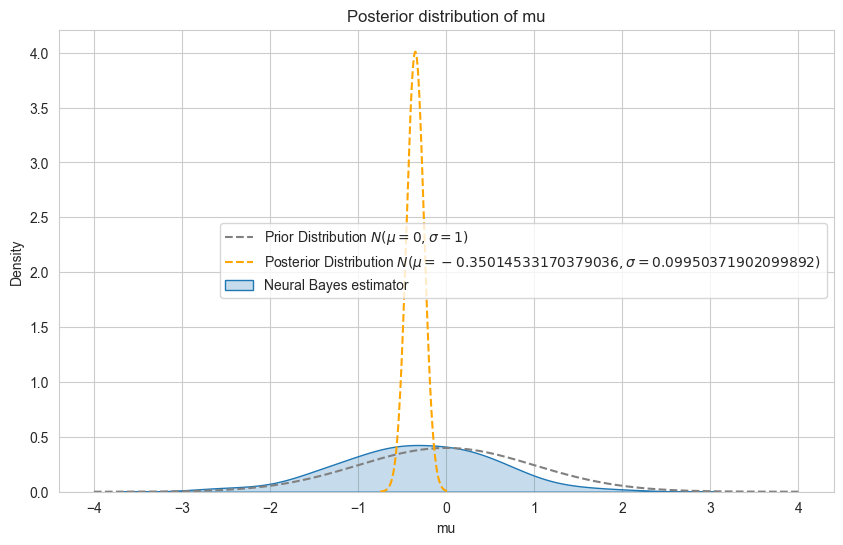

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 定义 Normal 分布
normal_prior = torch.distributions.Normal(loc=torch.tensor(mu_prior), scale=torch.tensor(sigma_prior))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_prior = torch.linspace(mu_prior - 4 * sigma_prior, mu_prior + 4 * sigma_prior, 500)
pdf_normal_prior = torch.exp(normal_prior.log_prob(x_prior))

# 添加 Prior Distribution 的曲线
ax.plot(x_prior.numpy(), pdf_normal_prior.numpy(), 
        label=f"Prior Distribution $N(\mu={mu_prior}, \sigma={sigma_prior})$", 
        color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 定义 Normal 分布
normal_poster = torch.distributions.Normal(loc=torch.tensor(mu_poster), scale=torch.tensor(sigma_poster))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_poster = torch.linspace(mu_poster - 4 * sigma_poster, mu_poster + 4 * sigma_poster, 500)
pdf_normal_poster = torch.exp(normal_poster.log_prob(x_poster))

# 添加 Posterior Distribution 的曲线
ax.plot(x_poster.numpy(), pdf_normal_poster.numpy(), 
        label=f"Posterior Distribution $N(\mu={mu_poster}, \sigma={sigma_poster})$", 
        color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

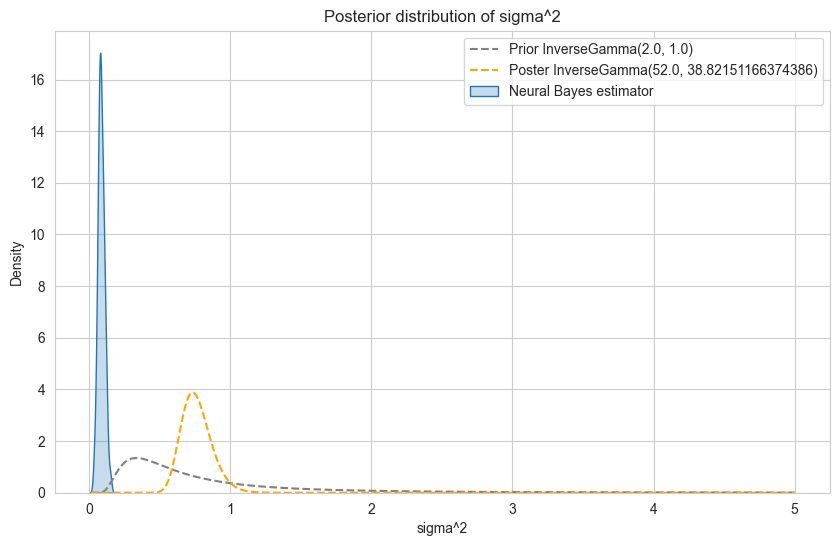

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 定义 InverseGamma 分布
concentration = torch.tensor(2.0)  # 形状参数 α
rate = torch.tensor(1.0)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Prior InverseGamma({concentration}, {rate})", color="grey", linestyle="--")

# 定义 InverseGamma 分布
concentration = torch.tensor(alpha_poster)  # 形状参数 α
rate = torch.tensor(beta_poster)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Poster InverseGamma({concentration}, {rate})", color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Summary vector shape:  (1, 100, 10)
Posterior samples shape:  (100, 2)


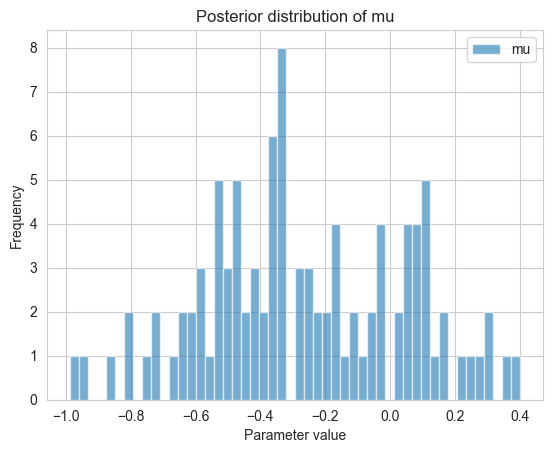

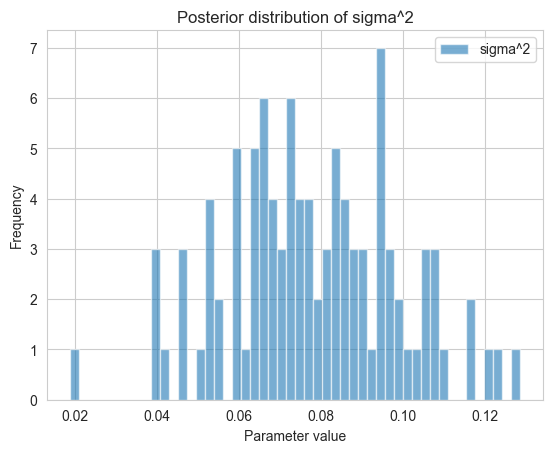

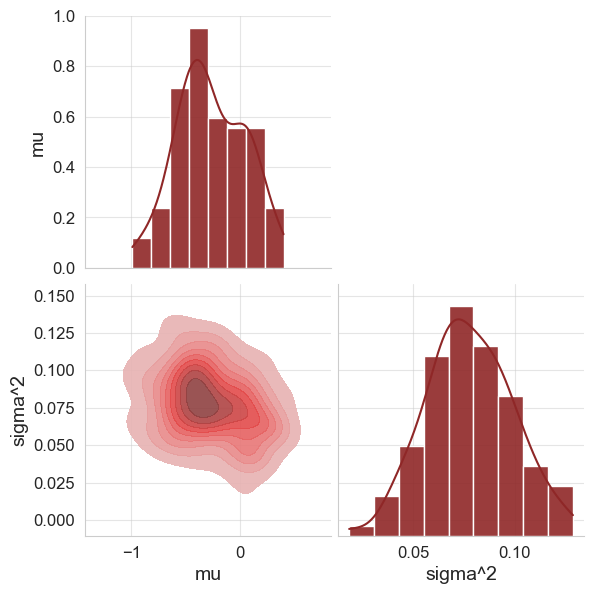

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 生成真实数据
# 假设真实数据从 N(0, 1) 分布生成
n_obs = 100  # 样本数量
true_miu = -0.3  # 真实均值
true_sigma = 0.3  # 真实标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

# 2. 使用总结网络提取观测数据特征
# 总结网络将数据转换为固定长度的特征向量
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # 应输出形状 (1, summary_dim)

# 3. 推断后验分布
# 使用推断网络对观测数据进行推断
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=100)
print("Posterior samples shape: ", posterior_samples.shape)  # 应输出形状 (1000, 2)

# 4. 可视化后验分布
# 参数名称
param_names = ["mu", "sigma^2"]

# 绘制每个参数的后验分布直方图
for i in range(posterior_samples.shape[1]):  # 遍历 mu 和 sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()

# 5. 可视化参数的二维联合分布
# 使用诊断工具绘制联合分布
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [153]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = 100  # 样本数量

# 计算样本总方差
variance = np.sum((Z - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 52.0
Posterior beta: 5.892067707356441
Posterior mu (mean): -0.3056777880923583
Posterior sigma^2 (variance): 0.009900990099009901


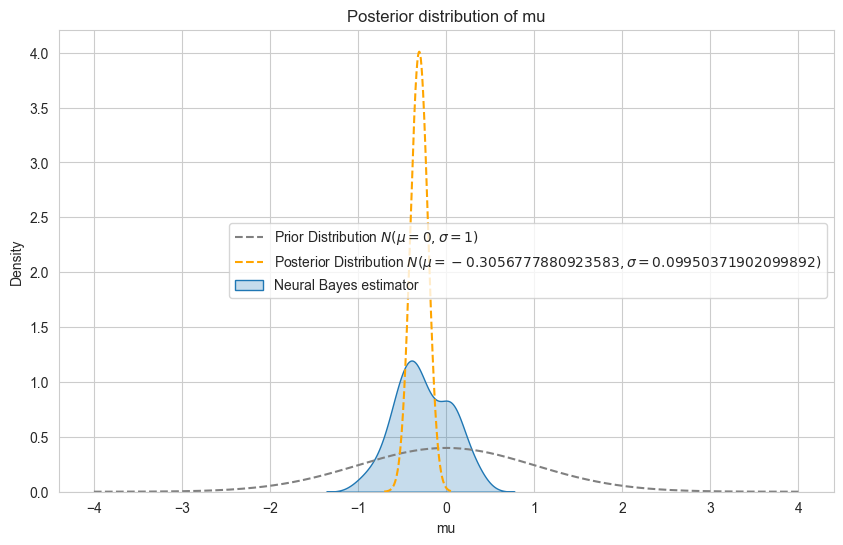

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 设置 Prior 分布的参数
mu_prior = 0  # 均值
sigma_prior = 1  # 标准差

# 定义 Normal 分布
normal_prior = torch.distributions.Normal(loc=torch.tensor(mu_prior), scale=torch.tensor(sigma_prior))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_prior = torch.linspace(mu_prior - 4 * sigma_prior, mu_prior + 4 * sigma_prior, 500)
pdf_normal_prior = torch.exp(normal_prior.log_prob(x_prior))

# 添加 Prior Distribution 的曲线
ax.plot(x_prior.numpy(), pdf_normal_prior.numpy(), 
        label=f"Prior Distribution $N(\mu={mu_prior}, \sigma={sigma_prior})$", 
        color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 定义 Normal 分布
normal_poster = torch.distributions.Normal(loc=torch.tensor(mu_poster), scale=torch.tensor(sigma_poster))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_poster = torch.linspace(mu_poster - 4 * sigma_poster, mu_poster + 4 * sigma_poster, 500)
pdf_normal_poster = torch.exp(normal_poster.log_prob(x_poster))

# 添加 Posterior Distribution 的曲线
ax.plot(x_poster.numpy(), pdf_normal_poster.numpy(), 
        label=f"Posterior Distribution $N(\mu={mu_poster}, \sigma={sigma_poster})$", 
        color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

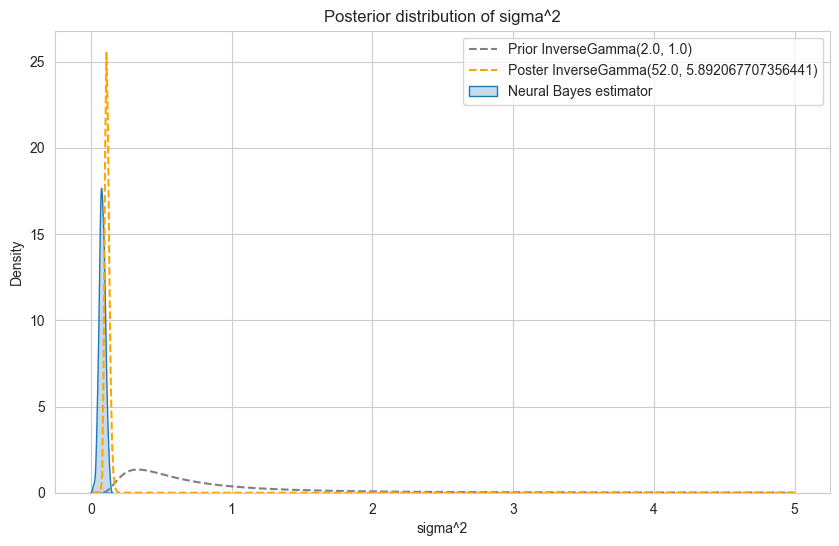

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 定义 InverseGamma 分布
concentration = torch.tensor(2.0)  # 形状参数 α
rate = torch.tensor(1.0)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Prior InverseGamma({concentration}, {rate})", color="grey", linestyle="--")

# 定义 InverseGamma 分布
concentration = torch.tensor(alpha_poster)  # 形状参数 α
rate = torch.tensor(beta_poster)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Poster InverseGamma({concentration}, {rate})", color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Summary vector shape:  (1, 100, 10)
Posterior samples shape:  (100, 2)


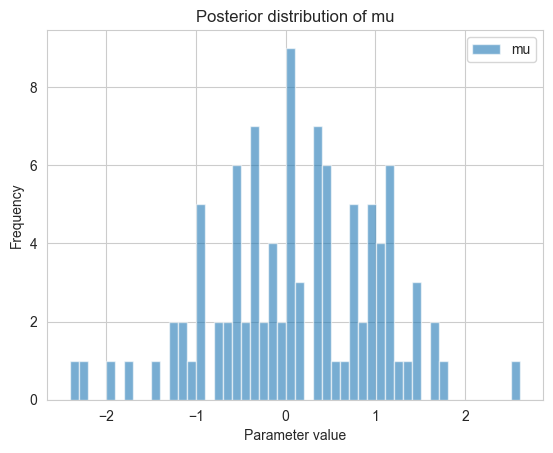

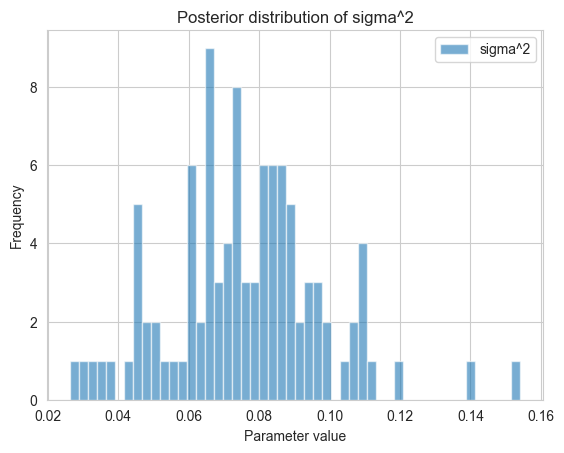

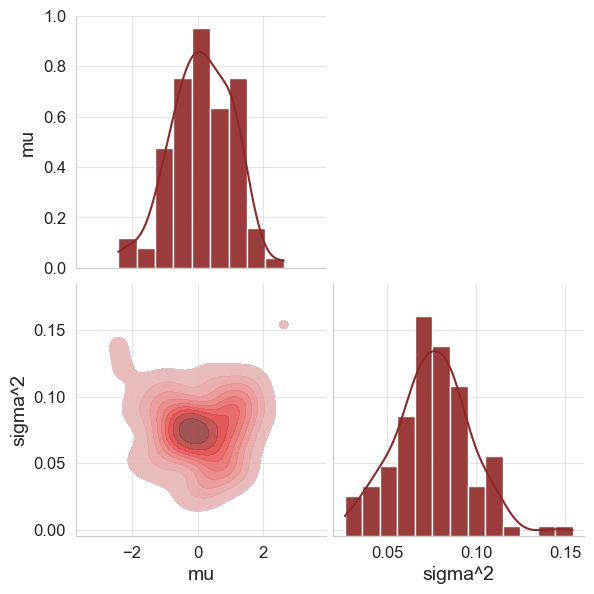

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 生成真实数据
# 假设真实数据从 N(0, 1) 分布生成
n_obs = 100  # 样本数量
true_miu = 0  # 真实均值
true_sigma = 1  # 真实标准差
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # 如果是 PyTorch 张量，转换为 NumPy 数组
obs_data = obs_data[np.newaxis, :, :]  # 调整形状为 (1, n_obs, 1)

# 2. 使用总结网络提取观测数据特征
# 总结网络将数据转换为固定长度的特征向量
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # 应输出形状 (1, summary_dim)

# 3. 推断后验分布
# 使用推断网络对观测数据进行推断
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=100)
print("Posterior samples shape: ", posterior_samples.shape)  # 应输出形状 (1000, 2)

# 4. 可视化后验分布
# 参数名称
param_names = ["mu", "sigma^2"]

# 绘制每个参数的后验分布直方图
for i in range(posterior_samples.shape[1]):  # 遍历 mu 和 sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()

# 5. 可视化参数的二维联合分布
# 使用诊断工具绘制联合分布
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [157]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = 100  # 样本数量

# 计算样本总方差
variance = np.sum((Z - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 52.0
Posterior beta: 45.148479512888926
Posterior mu (mean): 0.09662643222525569
Posterior sigma^2 (variance): 0.009900990099009901


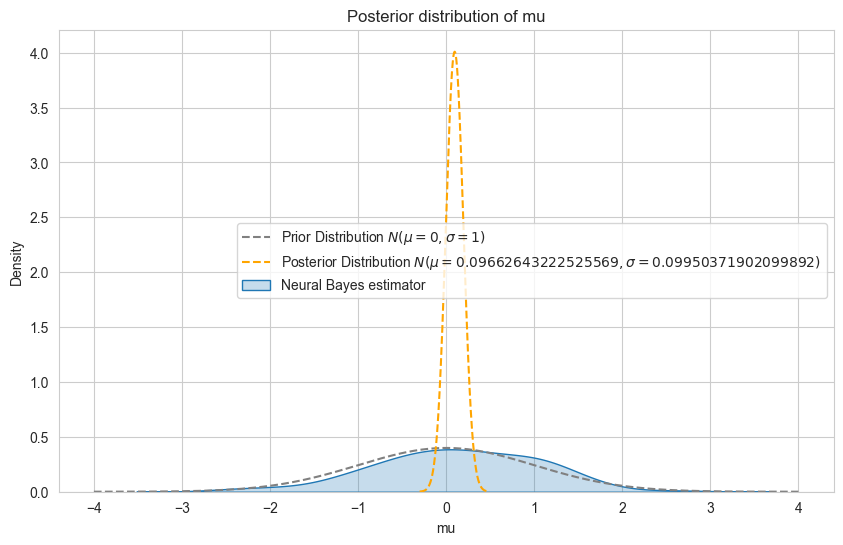

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Prior
mu_prior = 0  
sigma_prior = 1 

# Normal
normal_prior = torch.distributions.Normal(loc=torch.tensor(mu_prior), scale=torch.tensor(sigma_prior))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_prior = torch.linspace(mu_prior - 4 * sigma_prior, mu_prior + 4 * sigma_prior, 500)
pdf_normal_prior = torch.exp(normal_prior.log_prob(x_prior))

# 添加 Prior Distribution 的曲线
ax.plot(x_prior.numpy(), pdf_normal_prior.numpy(), 
        label=f"Prior Distribution $N(\mu={mu_prior}, \sigma={sigma_prior})$", 
        color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# 定义 Normal 分布
normal_poster = torch.distributions.Normal(loc=torch.tensor(mu_poster), scale=torch.tensor(sigma_poster))

# 生成 x 轴范围用于绘制 Normal 的 PDF
x_poster = torch.linspace(mu_poster - 4 * sigma_poster, mu_poster + 4 * sigma_poster, 500)
pdf_normal_poster = torch.exp(normal_poster.log_prob(x_poster))

# 添加 Posterior Distribution 的曲线
ax.plot(x_poster.numpy(), pdf_normal_poster.numpy(), 
        label=f"Posterior Distribution $N(\mu={mu_poster}, \sigma={sigma_poster})$", 
        color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

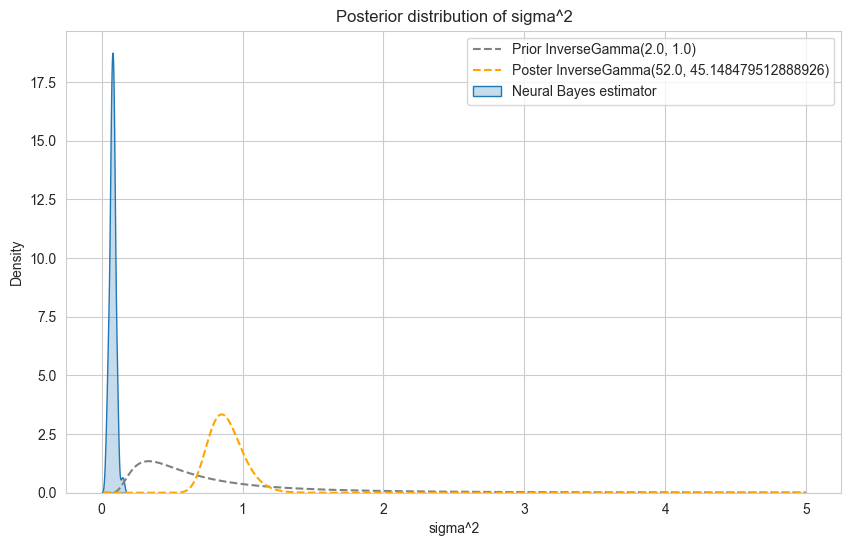

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

# 定义 InverseGamma 分布
concentration = torch.tensor(2.0)  # 形状参数 α
rate = torch.tensor(1.0)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Prior InverseGamma({concentration}, {rate})", color="grey", linestyle="--")

# 定义 InverseGamma 分布
concentration = torch.tensor(alpha_poster)  # 形状参数 α
rate = torch.tensor(beta_poster)           # 率参数 β
inverse_gamma = InverseGamma(concentration, rate)
# 生成 x 轴范围用于绘制 InverseGamma 的 PDF
x = torch.linspace(0.01, 5, 500)  # 从 0.01 开始避免 x=0 导致无穷大
pdf_inverse_gamma = torch.exp(inverse_gamma.log_prob(x))  # 计算逆伽马分布的概率密度

# 添加 InverseGamma 分布的曲线
ax.plot(x.numpy(), pdf_inverse_gamma.numpy(), label=f"Poster InverseGamma({concentration}, {rate})", color="orange", linestyle="--")

# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()
